In [1]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def read_pixel_file(pixel_file,in_file):
    ''' Reads in .pixel file from tRIBS model results and updates hourly timestep to time'''
    
    data = pd.read_csv(pixel_file,sep=r"\s+",header=0)

    #update time from hourly time step to date
    starting_date = read_starting_date(in_file)
    date = convert_to_datetime(starting_date)
    dt = pd.to_timedelta(data['Time_hr'], unit='h')
    data['Time_hr'] = [date+step for step in dt]
    
    return data

In [3]:
def read_starting_date(file_path):
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('STARTDATE:'):
                starting_date = next(f).strip()
                return starting_date

In [4]:
def convert_to_datetime(starting_date):
    month=int(starting_date[0:2])
    day=int(starting_date[3:5])
    year=int(starting_date[6:10])
    minute=int(starting_date[11:13])
    second=int(starting_date[14:16])
    date = pd.Timestamp(year=year,month=month,day=day,minute=minute)
    return date

In [5]:
def water_balance_element(data,begin,end,bedrock_depth,porosity,element_area):
    '''
    Computes water balance calculations for and individual computational element or node. Data = pandas data frame of .pixel file, begin is start date, end is end date,
    bedrock depth is the depth to bedock, porosity is well, porosity, and element area is surface area of voronoi polygon. Returns a dictionary with individual water components, keys with the prescript 
    d indicate change in storage (i.e. delta) and n indicates net cummulative flux.
    '''
    
    # logical index for calculating water balance
    begin_id = data['Time_hr'].values == begin
    end_id = data['Time_hr'].values == end
    duration_id = (data['Time_hr'].values>=begin) & (data['Time_hr'].values<=end)

    #return dictionary with values
    WB = {}

    #Store ET flux as series due to complexity
    ET = data['EvpTtrs_mm/h']-(data.SnSub_cm*10+data.SnEvap_cm*10+data.IntSub_cm*10); #Snow evaporative fluxes are subtracted due to signed behavior in snow module
    
    # calculate individual water balance components
    WB.update({'dUnsat':data.Mu_mm.values[end_id][0] - data.Mu_mm.values[begin_id][0]}) #[0] converts from array to float
    WB.update({'dSat':(data.Nwt_mm.values[begin_id][0] - data.Nwt_mm.values[end_id][0])*porosity})
    WB.update({'dCanopySWE':(10*(data.IntSWEq_cm.values[end_id][0]-data.IntSWEq_cm.values[begin_id][0]))}) #convert from cm to mm
    WB.update({'dSWE':(10*(data.SnWE_cm.values[end_id][0]-data.SnWE_cm.values[begin_id][0]))})
    WB.update({'dCanopy':data.CanStorage_mm.values[end_id][0]-data.CanStorage_mm.values[begin_id][0]})
    WB.update({'nP':np.sum(data['Rain_mm/h'].values[ duration_id])})
    WB.update({'nET':np.sum(ET.values[duration_id])})
    WB.update({'nQsurf':np.sum(data['Srf_Hour_mm'].values[ duration_id])})
    WB.update({'nQunsat':np.sum(data['QpIn_mm/h'].values[ duration_id])-np.sum(data['QpOut_mm/h'].values[ duration_id])})
    WB.update({'nQsat':np.sum(data['GWflx_m3/h'].values[ duration_id])/element_area*1000}) # convert from m^3/h to mm/h
    
    return WB

In [6]:
def create_water_balance(data,bedrock_depth,porosity,element_area,method):
    ''' creates a dictionary with water balance calculated specified in method: water_year", segements up time frame by water year and discards results that do not start first or end on last
    water year in data. "year", just segments based on year, "month" segments base on month, and "cold_warm",segements on cold (Oct-April) and warm season (May-Sep).
    '''
    begin,end,years = water_balance_dates(data,method)
    
    for n in range(0,len(years)):
        if n == 0:
            WB = water_balance_element(data,begin[n],end[n],bedrock_depth,porosity,element_area)
        else:
            temp = water_balance_element(data,begin[n],end[n],bedrock_depth,porosity,element_area)

            for key,val in temp.items():
          
                if key in WB:
                    WB[key] = np.append(WB[key], val)

    return WB,years
        


In [7]:
def water_balance_dates(data,method):
    ''' 
    data = pandas data frame of .pixel file, methods select approach for segmenting data['Time_hr']. "water_year", segements up time frame by water year and discards results that do not start first or end on last
    water year in data. "year", just segments based on year, "month" segments base on month, and "cold_warm",segements on cold (Oct-April) and warm season (May-Sep).
    '''
    min_date = min(data.Time_hr)
    max_date = max(data.Time_hr)
    
    if method == "water_year":
        years = np.arange(min_date.year,max_date.year)
        begin_dates = [pd.Timestamp(year=x,month=10,day=1,hour=0,minute=0,second=0) for x in years]
        years += 1
        end_dates = [pd.Timestamp(year=x,month=9,day=30,hour=23,minute=0,second=0) for x in years]

        # make sure water years are in data set
        while begin_dates[0]<min_date:
            begin_dates.pop(0)
            end_dates.pop(0)
        
        while end_dates[len(end_dates)-1]>max_date:
            begin_dates.pop(len(end_dates)-1)
            end_dates.pop(len(end_dates)-1)

    if method == "year":
        years = np.arange(min_date.year,max_date.year)
        begin_dates = [pd.Timestamp(year=x,month=1,day=1,hour=0,minute=0,second=0) for x in years]
        end_dates = [pd.Timestamp(year=x,month=12,day=31,hour=23,minute=0,second=0) for x in years]

        # adjust start date according to min_date
        begin_dates[0] = min_date

        # add ending date according to end_date
        end_dates.append(max_date)

        # add last year to years
        years = np.append(years,max_date.year)

    if method == "cold_warm":
        years = np.arange(min_date.year,max_date.year+1)
        begin_dates = [[pd.Timestamp(year=x,month=5,day=1,hour=0,minute=0,second=0),pd.Timestamp(year=x,month=10,day=1,hour=0,minute=0,second=0)]  for x in years]
        begin_dates = [date for sublist in begin_dates for date in sublist]
        end_dates = [[pd.Timestamp(year=x,month=9,day=30,hour=23,minute=0,second=0),pd.Timestamp(year=x+1,month=4,day=30,hour=23,minute=0,second=0)] for x in years]
        end_dates = [date for sublist in end_dates for date in sublist]
        
        # make sure season are in data set
        while begin_dates[0]<min_date:
            begin_dates.pop(0)
            end_dates.pop(0)
        
        while end_dates[len(end_dates)-1]>max_date:
            begin_dates.pop(len(end_dates)-1)
            end_dates.pop(len(end_dates)-1)
        
    #Update date time to reflect middle of period overwhich the waterbalance is calculated
    years = [x+(y-x)/2 for x,y in zip(begin_dates,end_dates)]
    return begin_dates,end_dates,years

# New Snow Merge

In [28]:
#if __name__ == "__main__":
pixel_file = "../results/2023-09-05/5/results/5_0.pixel" 
in_file = "../results/2023-09-05/5/input.in"
data = read_pixel_file(pixel_file,in_file)

WB,years = create_water_balance(data,15,0.4,98,"water_year")
WB = pd.DataFrame.from_dict(WB)
WB['year'] = years
WB.set_index('year',inplace=True)
WB['dS'] = np.add(np.add(WB['dUnsat'],WB['dSat'],WB['dCanopySWE']),WB['dSWE'],WB['dCanopy']) # change in storage
WB['nQ'] = np.add(WB['nQsurf'],WB['nQunsat'],WB['nQsat']) #net fluxes from surface and saturated and unsaturated zone

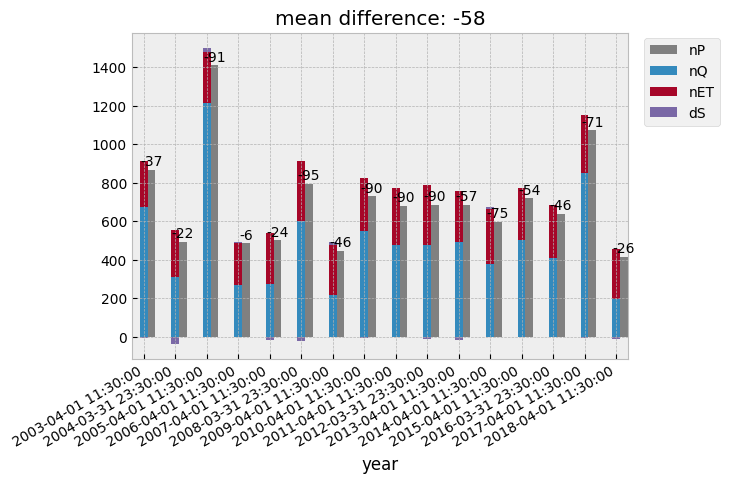

In [29]:
# need to remove hours year date
plt.style.use('bmh')
barwidth = 0.25
fig, ax = plt.subplots()
#WB.plot.bar(ax=ax,y=["nQ","nET","dS"],stacked=True,width=barwidth)
ax.bar(np.arange(len(WB))+barwidth, WB['nP'], align='center', width=barwidth, color = 'grey',label='nP')
rects = ax.patches

# Make some labels.
labels = ["%.0f" %(p-wb) for p,wb in zip(WB['nP'],WB['dS']+WB['nQ']+WB['nET'])]
netdiff = [p-wb for p,wb in zip(WB['nP'],WB['dS']+WB['nQ']+WB['nET'])]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

ax.set_title("mean difference: "+"%.0f" % np.mean(netdiff))
    
WB.plot.bar(ax=ax,y=["nQ","nET","dS"],stacked=True,width=barwidth)
ax.legend(bbox_to_anchor = (1.2, 0.85), loc='center right')
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-m"))
fig.autofmt_xdate()
plt.savefig('results')




In [30]:
pd.set_option('display.max_columns', None)
data.head()

,NodeID,Time_hr,Nwt_mm,Nf_mm,Nt_mm,Mu_mm,Mi_mm,QpOut_mm/h,QpIn_mm/h,Trnsm_m2/h,GWflx_m3/h,Srf_mm,Rain_mm/h,SoilMoist_[],RootMoist_[],AirT_oC,DewT_oC,SurfT_oC,SoilT_oC,Press_Pa,RelHum_[],SkyCov_[],Wind_m/s,NetRad_W/m2,ShrtRadIn_W/m2,ShrtRadIn_dir_W/m2,ShrtRadIn_dif_W/m2,ShortAbsbVeg_W/m2,ShortAbsbSoi_W/m2,LngRadIn_W/m2,LngRadOut_W/m2A,PotEvp_mm/h,ActEvp_mm/h,EvpTtrs_mm/h,EvpWetCan_mm/h,EvpDryCan_mm/h,EvpSoil_mm/h,Gflux_W/m2,HFlux_W/m2,Lflux_W/m2,NetPrecip_mm/hr,LiqWE_cm,IceWE_cm,SnWE_cm,SnSub_cm,SnEvap_cm,U_kJ/m2,RouteWE_cm,SnTemp_C,SurfAge_h,DU_kJ/m2/etistep,snLHF_kJ/m2/etistep,snSHF_kJ/m2/etistep,snGHF_kJ/m2/etistep,snPHF_kJ/m2/etistep,snRLout_kJ/m2/etistep,snRLin_kJ/m2/etistep,snRSin_kJ/m2/etistep,Uerror_kJ/m2/etistep,IntSWEq_cm,IntSub_cm,IntSnUnload_cm,CanStorage_mm,CumIntercept_mm,Interception_mm,Recharge_mm/hr,RunOn_mm,Srf_Hour_mm,Qstrm_m3/s,Hlevel_m,CanStorParam_mm,IntercepCoeff_[],ThroughFall_[],CanFieldCap_mm,DrainCoeff_mm/hr,DrainExpPar_1/mm,LandUseAlb_[],VegHeight_m,OptTransmCoeff_[],StomRes_s/m,VegFraction[],LeafAI_[]
0,0,2002-06-01 00:00:00,10000.000000,0.0,0.0,1378.357311,1378.357311,0.0,0.0,0.0,0.0,0.0,0.0,0.276085,0.277893,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.12,0.5,1.5,0.12,3.5,0.2,25.0,0.5,175.0,0.44,5.5
1,0,2002-06-01 01:00:00,10000.031143,0.0,0.0,1378.360748,1378.360748,0.0,0.0,0.0,0.0,0.0,0.0,0.276085,0.277893,27.21857,-3.676738,25.813814,27.177666,793.8,13.0,0.0,1.117,-91.029666,215.70,0.000000,0.000000,0.0,0.000000,349.400621,440.430286,0.278056,0.015645,0.009164,0.0,0.000402,0.008761,-78.136072,-23.479429,10.585826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.12,0.5,1.5,0.12,3.5,0.2,25.0,0.5,175.0,0.44,5.5
2,0,2002-06-01 02:00:00,10000.110984,0.0,0.0,1378.369559,1378.369559,0.0,0.0,0.0,0.0,0.0,0.0,0.276085,0.277893,25.54857,-4.007525,25.912491,27.180637,793.8,14.0,0.0,1.028,-53.602316,90.86,60.658581,13.002962,0.0,45.964803,341.444936,441.012055,0.281878,0.019804,0.023492,0.0,0.012402,0.011090,-72.652984,5.628806,13.421853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.12,0.5,1.5,0.12,3.5,0.2,25.0,0.5,175.0,0.44,5.5
3,0,2002-06-01 03:00:00,10000.183840,0.0,0.0,1378.377599,1378.377599,0.0,0.0,0.0,0.0,0.0,0.0,0.276085,0.277892,23.32857,-3.160904,23.985246,27.117748,793.9,17.0,0.0,0.983,-93.959337,9.77,4.080707,1.964990,0.0,3.772515,332.021583,429.753436,0.255921,0.018151,0.021437,0.0,0.011273,0.010164,-116.075600,9.788429,12.327820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.12,0.5,1.5,0.12,3.5,0.2,25.0,0.5,175.0,0.44,5.5
4,0,2002-06-01 04:00:00,10000.244043,0.0,0.0,1378.384243,1378.384243,0.0,0.0,0.0,0.0,0.0,0.0,0.276084,0.277892,21.65857,-1.639758,22.337545,27.056117,793.9,21.0,0.0,0.849,-94.519879,0.00,0.000000,0.000000,0.0,0.000000,325.780125,420.300004,0.205495,0.015345,0.017714,0.0,0.009121,0.008593,-113.753771,8.794566,10.439311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.12,0.5,1.5,0.12,3.5,0.2,25.0,0.5,175.0,0.44,5.5


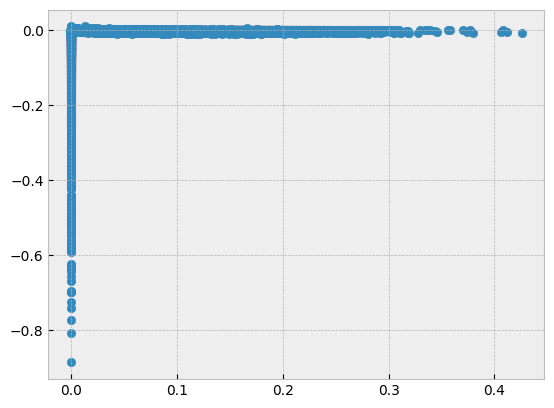

In [31]:
plt.scatter(data['EvpTtrs_mm/h'],data.SnSub_cm*10+data.SnEvap_cm*10+data.IntSub_cm*10)

(array([1.38924e+05, 2.14300e+03, 1.03600e+03, 5.17000e+02, 2.99000e+02,
        1.52000e+02, 6.90000e+01, 2.50000e+01, 7.00000e+00, 1.20000e+01]),
 array([0.      , 0.000924, 0.001848, 0.002772, 0.003696, 0.00462 ,
        0.005544, 0.006468, 0.007392, 0.008316, 0.00924 ]),
 <BarContainer object of 10 artists>)

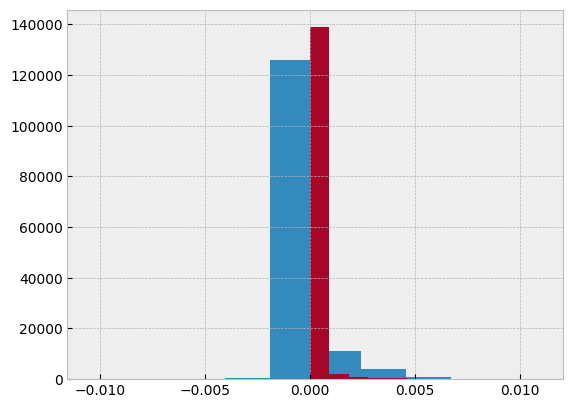

In [32]:
plt.hist(-data.SnEvap_cm.values*10)
plt.hist(-data.SnSub_cm.values*10)

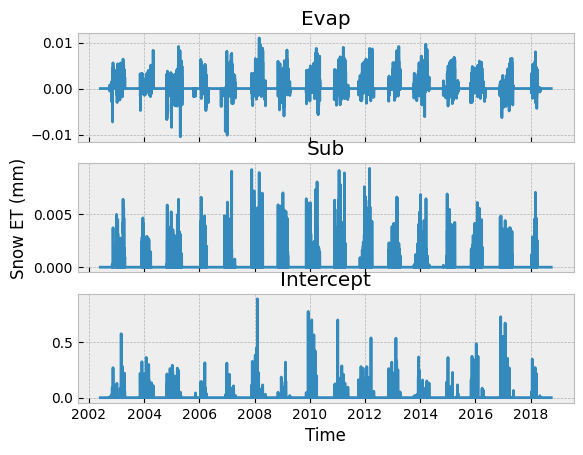

In [57]:
fig,axs =plt.subplots(3,1)
axs[0].plot(data.Time_hr,-data['SnEvap_cm']*10)
axs[0].set_title('Evap')
axs[1].plot(data.Time_hr,-data['SnSub_cm']*10)
axs[1].set_title('Sub')
axs[1].set_ylabel('Snow ET (mm)')
axs[2].set_title('Intercept')
axs[2].plot(data.Time_hr,-data['IntSub_cm']*10)
plt.xlabel('Time')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

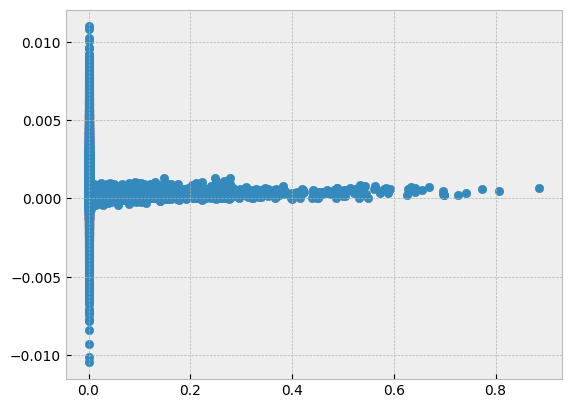

In [58]:
plt.scatter(-(data.IntSub_cm*10),-(data.SnSub_cm*10+data.SnEvap_cm*10))

# Prior to Snow Merge

In [17]:
pixel_file = "../results/2023-08-17/1/results/1_0.pixel" 
in_file = "../results/2023-08-17/1/input.in"
data_old = read_pixel_file(pixel_file,in_file)

WB,years = create_water_balance(data_old,15,0.4,98,"water_year")
WB = pd.DataFrame.from_dict(WB)
WB['year'] = years
WB.set_index('year',inplace=True)
WB['dS'] = np.add(np.add(WB['dUnsat'],WB['dSat'],WB['dCanopySWE']),WB['dSWE'],WB['dCanopy']) # change in storage
WB['nQ'] = np.add(WB['nQsurf'],WB['nQunsat'],WB['nQsat']) #net fluxes from surface and saturated and unsaturated zone

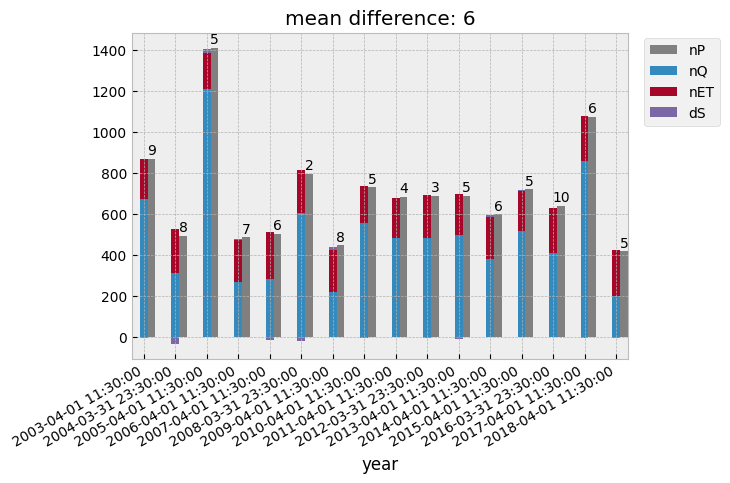

In [18]:
# need to remove hours year date
plt.style.use('bmh')
barwidth = 0.25
fig, ax = plt.subplots()
#WB.plot.bar(ax=ax,y=["nQ","nET","dS"],stacked=True,width=barwidth)
ax.bar(np.arange(len(WB))+barwidth, WB['nP'], align='center', width=barwidth, color = 'grey',label='nP')
rects = ax.patches

# Make some labels.
labels = ["%.0f" %(p-wb) for p,wb in zip(WB['nP'],WB['dS']+WB['nQ']+WB['nET'])]
netdiff = [p-wb for p,wb in zip(WB['nP'],WB['dS']+WB['nQ']+WB['nET'])]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

ax.set_title("mean difference: "+"%.0f" % np.mean(netdiff))
    
WB.plot.bar(ax=ax,y=["nQ","nET","dS"],stacked=True,width=barwidth)
ax.legend(bbox_to_anchor = (1.2, 0.85), loc='center right')
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-m"))
fig.autofmt_xdate()
plt.savefig('results')

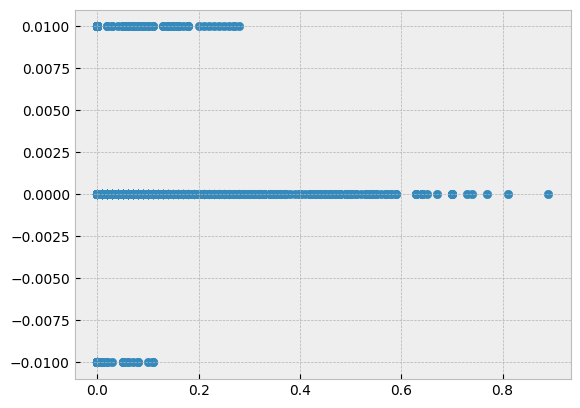

In [19]:
plt.scatter(-(data_old.IntSub_cm*10),-(data_old.SnSub_cm*10+data_old.SnEvap_cm*10))